># <font color='blue'>Автокорректор ошибок </font>
На основе блокнота Яна Пиле, который перевел блокнот Питера Норвига, Google \
https://norvig.com/spell-correct.html

In [124]:
%pylab inline
import re #регулярные выражения
import math
from collections import Counter
import requests

Populating the interactive namespace from numpy and matplotlib


In [125]:
TEXT = requests.get('https://norvig.com/big.txt').text
print(len(TEXT))
print(TEXT[:90])

6488666
The Project Gutenberg EBook of The Adventures of Sherlock Holmes
by Sir Arthur Conan Doyle


In [126]:
#разбиваем текст на слова(токены) не учитываются слова с дефисами, цифры, слова повторяются
def tokens(text):
    return re.findall(r'[a-z]+',text.lower())

#проверяем работу функции
#tokens('This is: A test, 1, 2, 3, this is.')

In [173]:
WORDS = tokens(TEXT)
print(len(WORDS))
print(WORDS[:10])

1105285
['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes']


>### <font color='blue'>Мешок слов (Bag of words)</font>
В модели мешка слов полностью игнорируется порядок слов, зато соблюдается их частота. \
Смысл мешка слов: все слова текста сбрасываются в мешок и перемешиваются. Если достать случайные слова, предложение из них будет некорректным. Зато наиболее частые слова действительно будут встречаться наиболее часто, а редкие - реже. \
Реализация:

In [128]:
def sample(bag, n=10):
    return ' '.join(random.choice(bag) for _ in range(n))

sample(WORDS)

'of tsar coat him you action with of that going'

>Другое представление мешка слов - <b>Counter</b>.\
Это похож на словарь, состоящий из пар <code>{'слово': кол-во вхождений слова в текст}</code> \
Но у него есть много своих методов. \
Пример:

In [129]:
COUNTS = Counter(WORDS)
print(COUNTS.most_common(10))

[('the', 80030), ('of', 40025), ('and', 38313), ('to', 28766), ('in', 22050), ('a', 21155), ('that', 12512), ('he', 12401), ('was', 11410), ('it', 10681)]


In [130]:
#насколько часто встречаются слова из этого преложения в тексте?
for w in tokens('the rare and neverrbeforeseen words'):
    print(COUNTS[w], w)
    
print(len(COUNTS))

80030 the
83 rare
38313 and
0 neverrbeforeseen
460 words
29157


>В 1935, лингвист Джордж Ципф отметил, что в любом большом тексте n-тое наиболее часто встречающееся слово появляется с частотой ~(пропорционально) 1/n от частоты наиболее встречающегося слова. Это наблюдение называется <b>Закон Ципфа</b>.\
Если нарисовать частоты слов, начиная от самого часто встречающегося, на log-log-графике, они должны приблизителньо следовать прямой линии.


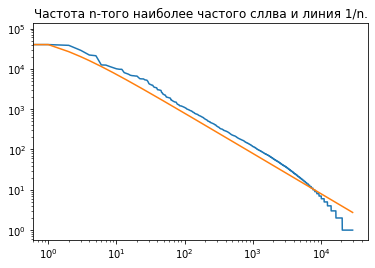

In [131]:
#логарифмируем обе части выражения
M = COUNTS['the']
yscale('log');
xscale('log');
title('Частота n-того наиболее частого сллва и линия 1/n.')
plot([c for(w,c) in COUNTS.most_common()])
plot([M/i for i in range(1,len(COUNTS))]);

>### <font color='blue'>Задача проверки правописания</font>
<b>Letter insertion</b> - вставка лишней буквы \
<b>Letter omission</b> - пропуск буквы \
<b>Letter substitution</b> - замена буквы \
<b>Transposition</b> - переставление букв местами \
<b>Compounding</b> - склеивание слов \
<b>Apostrophe</b> - неверная постановка апострофа \

>Задача: для данного слова нужно найти наиболее вероятную правку <code>c = correct(w)</code> \
Применим наивный подход: всегда будем брать более близкое слово, если проверки на близость недостаточно, берем слово с максимальной частотой из WORDS.\
Близость можно измерить с помощью <b>Расстояния Левенштейна</b>: минимального необходимого количества удалений, перестановок, вставок и замен символов, необходимых чтобы одно слово превратилось в другое. \
Методом проб и ошибок можно понять, что поиск слов в пределах расстояния 2 уже даст пристойныее результаты. \
Остается определить функцию <code>c = correct(w)</code> :

In [154]:
def correct(word):
    #предрассчитать edit_distance==0, затем 1, затем 2, иначе: оставить слово "как есть"
    candidates = (known(edits0(word)) or
                  known(edits1(word)) or
                  known(edits2(word)) or
                  [word])
    return max(candidates, key=COUNTS.get)

>Функция edits1(word) должна возвращать множество слов, находящихся на расстоянии edit_distance==1. \
Пример работы алгоритма: 

>||||||||
|-----|-------|------|------|------|------|------|
|пары:|x+wird|w+ird|wi+rd|wir+d|wird+x|<i>Notes:(a,b) пара</i>
|удаления:|x+ird|w+rd|wi+d|wir+x||<i>Удаление первой буквы в b</i>
|перемена мест:|x+iwrd|w+rid|wi+dr|||<i>Перемена мест двух первых букв b</i>
|замена:|x+?ird|w+?rd|wi+?d|wir+?||<i>Замена букв в начале b</i>
|вставка:|x+?+wird|w+?+ird|wi+?+rd|wir+?+d|wird+?+x|<i>Вставка буквы между a и b</i>



In [155]:
def edits1(word):
    pairs      = splits(word)
    deletes    = [a+b[1:]            for (a,b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:]  for (a,b) in pairs if len(b)>1]
    replaces   = [a+c+b[1:]          for (a,b) in pairs for c in alphabet if b]
    inserts    = [a+c+b              for (a,b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    return [(word[:i], word[i:])
            for i in range (len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [156]:
def known(words):
    return {w for w in words if w in COUNTS}

def edits0(word):
    return {word}

def edits2(word):
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

In [157]:
splits('wird')

[('', 'wird'), ('w', 'ird'), ('wi', 'rd'), ('wir', 'd'), ('wird', '')]

In [158]:
print(edits1('wird'))
print(len(edits1('wird')))
print(len(edits2('wird'))) #код мягко говоря не очень оптимальный

{'wirvd', 'widrd', 'wnird', 'wifrd', 'wirfd', 'wcrd', 'whird', 'wirdt', 'wmird', 'winrd', 'wigd', 'tird', 'wirgd', 'nwird', 'wjird', 'wivd', 'wrd', 'jwird', 'wirdr', 'wbrd', 'wirp', 'wircd', 'kird', 'wdrd', 'kwird', 'wizd', 'wirad', 'wtird', 'jird', 'wwrd', 'wirkd', 'wirh', 'wirdd', 'iwird', 'wirxd', 'zird', 'xwird', 'bird', 'wfird', 'wrid', 'fwird', 'wiard', 'wisd', 'wirq', 'wtrd', 'wisrd', 'yird', 'wxrd', 'wirs', 'wir', 'mwird', 'wirde', 'lwird', 'iwrd', 'wirtd', 'wirdj', 'wiurd', 'wirdn', 'wirdx', 'wiird', 'wild', 'witrd', 'wiid', 'xird', 'pird', 'fird', 'wiqrd', 'wzird', 'nird', 'wire', 'wired', 'wirdq', 'ywird', 'wirrd', 'ward', 'wgrd', 'hird', 'wirc', 'wirz', 'woird', 'wikrd', 'wicd', 'wixrd', 'wnrd', 'cwird', 'pwird', 'wiyd', 'wied', 'wibrd', 'wipd', 'wprd', 'wqrd', 'wlird', 'wirb', 'sird', 'wirdb', 'wilrd', 'word', 'wirdy', 'zwird', 'aird', 'wrrd', 'owird', 'wikd', 'wyird', 'wkird', 'wiprd', 'wirf', 'wirzd', 'wiryd', 'wiru', 'wiry', 'wvird', 'wiyrd', 'wirg', 'wiro', 'wzrd', 'wi

In [159]:
tokens('Speling errurs in somethink. Whutever; ususuel misteakes everyware?)')

['speling',
 'errurs',
 'in',
 'somethink',
 'whutever',
 'ususuel',
 'misteakes',
 'everyware']

In [160]:
list(map(correct, tokens('Speling errurs in somethink. Whutever; ususuel misteakes everyware?)')))

['spelling',
 'errors',
 'in',
 'something',
 'whatever',
 'unusual',
 'mistakes',
 'everywhere']

In [170]:
#давайте возвращать слово в регистре в котором оно встретилось
def correct_text(text):
    return re.sub('[a-zA-Z]+', correct_match, text)

def correct_match(match):
    word = match.group()
    return case_of(word)(correct(word.lower()))

#возвращает функцию преобразовывающую слово в определенный регистр
def case_of(text):
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [171]:
list(map(case_of,['UPPER','lower','Title','CamelCase']))

[<method 'upper' of 'str' objects>,
 <method 'lower' of 'str' objects>,
 <method 'title' of 'str' objects>,
 str]

In [172]:
correct_text('Speling Errurs IN somethink. Whutever; ususuel misteakes?')

'Spelling Errors IN something. Whatever; unusual mistakes?'

>### <font color='blue'>Теория: От счетчика слов к вероятностям последовательностей слов</font>
Нам нужно научиться подсчитывать вероятности слов,$ P(w)$. Делать это будем с помощью функции <code>pdist</code>, которая на вход принимает <code>Counter</code>(мешок слов) и возвращает функцию, выполняющую роль вероятностного распределения на множестве всех возможных слов. 


In [175]:
def pdist(counter):
    "Превращает частоты из Counter в вероятностное распределение"
    N = sum(list(counter.values()))
    return lambda x: counter[x]/N

P=pdist(COUNTS)

In [177]:
for w in tokens('"The" is the most common word in English'):
    print(P(w),w)

0.07240666434449033 the
0.008842968103249388 is
0.07240666434449033 the
0.0008215075749693518 most
0.0002596615352601365 common
0.0002696137195383996 word
0.019949605757790978 in
0.00019090098933759167 english
